# EAS 2021 workshop: Introduction to Machine Learning

By Eliot Ayache$^1$ & Tanmoy Laskar$^2$ (University of Bath)

$^1$ https://eliotayache.github.io/

$^2$ https://scholar.harvard.edu/laskar

Delivered on 29 June 2021 at the 2021 EAS Annual Meeting

*See the end of this document for reuse conditions and copyright information.*

**Special Session 32c (SS32c)**

[EAS Abstract](https://eas.kuoni-congress.info/2021/programme/grid/29.06.2021):
The objective of this workshop is to provide beginners in machine learning with hands-on experience in implementing and using statistical-learning methods as well as background knowledge necessary to identify the additional tools they would require to solve specific astrophysical problems. In this tutorial, participants will implement a full machine-learning method from scratch and apply it to an astrophysical problem, while being given the opportunity to get a grasp of the potential and limitations of these statistical methods.

## Resources
For more information on convolutional neural networks, see: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

For a related tutorial on Keras, see the BathML Keras workshop: https://github.com/owenjonesuob/keras-workshop 


In [ ]:
# Initial import statements
import numpy as np
import matplotlib.pyplot as plt

Our task is going to be to perform classification using supervised machine learning using an astronomy pseudo-example. We will classify images of galaxies into ellipticals and spirals using a convolutional neural network (CNN) with tensorflow.

## Generate synthetic data
To keep everything self-contained, we are going to generate our (synthetic) data directly in this tutorial. Let's start with the functions to make ellipticals and spirals.

In [ ]:
N_image = 28 # Number of pixels per side in image

# The getprimes function is just a coordinate transformation
# that makes it easy to calculate brightness as a function of pixel position
# for the ellipsoid and spiral functions below
def getprimes(theta):
  x = np.tile(np.linspace(-1,1,N_image).reshape(1,N_image), (N_image,1))
  y = np.tile(-np.linspace(-1,1,N_image).reshape(N_image,1), (1,N_image))
  sintheta = np.sin(theta)
  costheta = np.cos(theta)
  if np.ndim(theta) > 0:
    x_prime = np.einsum('ij,k->ijk',x,costheta) - \
              np.einsum('ij,k->ijk',y,sintheta)
    y_prime = np.einsum('ij,k->ijk',x,sintheta) + \
              np.einsum('ij,k->ijk',y,costheta)
  else:
    x_prime = x * costheta - y * sintheta
    y_prime = x * sintheta + y * costheta
  return x_prime, y_prime

def addnoise(image, sigma=0.1):
  noise_img = np.random.normal(0, sigma, image.shape)
  return image+noise_img

def ellipsoid(A,e,theta):
    B = A*(1.-e)    
    x_prime, y_prime = getprimes(theta)  
    r_prime = np.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    img = np.exp(-r_prime)
    noisy_img = addnoise(img)
    return(noisy_img)

def spiral(A,e,theta,orient=1):    
    A *= 2
    B = A*(1.-e)
    x_prime, y_prime = getprimes(theta)    
    r_prime = np.sqrt((x_prime/A)**2 + (y_prime/B)**2)
    theta_prime = np.arctan(x_prime/y_prime)
    img = np.maximum(np.exp(-r_prime*r_prime * 4)*(4.+np.cos(3* np.pi * r_prime + orient * 2 * theta_prime + np.pi / 2.)) / 5.,
                    np.exp(-r_prime*3))
    noisy_img = addnoise(img)
    return(noisy_img)

What do these functions do? Let's have a look at a couple of examples

In [ ]:
el = ellipsoid(A=0.5,e=0.3,theta=0.3); plt.imshow(el, cmap='Greys'); plt.show()
sp = spiral(A=0.7,e=0.3,theta=0.3); plt.imshow(sp, cmap='Greys'); plt.show()

Now let's make a bunch of these for training.


In [ ]:
N_els = 5000
N_sps = 5000
np.random.seed(seed=17)
els = ellipsoid(A    = np.random.uniform(low=0.3, high=0.9, size=N_els), 
                e    = np.random.uniform(low=0.1, high=0.5, size=N_els), 
                theta= np.random.uniform(low=0.1, high=0.9, size=N_els))
sps =    spiral(A    = np.random.uniform(low=0.3, high=0.9, size=N_sps), 
                e    = np.random.uniform(low=0.1, high=0.5, size=N_sps), 
                theta= np.random.uniform(low=0.1, high=0.9, size=N_sps),
                orient=np.random.randint(2, size=N_sps)*2-1)

Let's plot a random subset of these images to see what we've generated

In [ ]:
# Function to plot a random subset 
def plotrandomsubset(imagelist, n):  
  randx = np.random.randint(0,len(imagelist)-1,n*n)
  from mpl_toolkits.axes_grid1 import ImageGrid
  
  fig = plt.figure(figsize=(2*n, 2*n))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                  nrows_ncols=(n, n),  # creates nxn grid of axes
                  axes_pad=0.0,  # pad between axes in inch.
                  )
  for ax, im in zip(grid, [imagelist[:,:,i] for i in randx]):
      # Iterating over the grid returns the Axes.
      ax.imshow(im, cmap='Greys')
  plt.show()

We'll plot a 4x4 grid of images from each class

In [ ]:
print("Subset of elliptical class:")
plotrandomsubset(els, 4)

print("Subset of spiral class:")
plotrandomsubset(sps, 4)

Now things start getting interesting. Let's set up the labels for our input data. We will start with zeros for ellipticals and 1 for spirals. This will later be coded into numpy arrays using one-hot encoding (depending on the kind of encoding you use for the class labels, you will need to pick a compatible kind of cross-entropy during in the model training process, but we'll get to that later). 

In [ ]:
# 0 = elliptical, 1 = spiral
input_labels = np.array([[0]*N_els+[1]*N_sps])

This is a binary classification problem (0 or 1), and it is possible to proceed with these labels. But for flexibility, we are now going to transform the class labels from binary to categorical (one-hot-encoded) labels. This will be useful if we later on want to expand our model to try and classify data from more than two categories.


In [ ]:
from tensorflow.keras.utils import to_categorical
synthetic_labels_grouped = to_categorical(input_labels)[0]

What did that do? Let's take a look at the shape of the labels.

In [ ]:
print(synthetic_labels_grouped.shape)

The "grouped" reminds us that these labels are still grouped by N_els ellipticals followed by N_sps spirals:

In [ ]:
print(synthetic_labels_grouped[0])

In [ ]:
print(synthetic_labels_grouped[-1])

We'll shuffle it up in a second.

But first, we also need to concatenate the actual images of N_els ellipticals and N_sps spirals together.

In [ ]:
synthetic_data_grouped  = np.append(els, sps, axis=2)
synthetic_data_grouped.shape

OK, that has stacked all of the images together into a giant N_image x N_image x N_els + N_sps cube. It turns out that most ML algorithms require the sample number to be the *first* axis. So we need to move the third axis of this object to be the first. 

**Warning**

If you miss this step, it *will* cause trouble later!

In [ ]:
synthetic_data_grouped  = np.moveaxis(np.append(els, sps, axis=2), 2, 0)
print(synthetic_data_grouped.shape)

The order of the remaining axes is preserved by np.moveaxis(). 

Now we are going to shuffle the data and label rows so that they are not in any particular order. There are automatic tools for doing this, but we'll do it manually here because we want to make sure that the labels are shuffled in exactly the same way as the images.

In [ ]:
m = synthetic_data_grouped.shape[0]
shuffle_ix = np.arange(m)
np.random.shuffle(shuffle_ix)   

In [ ]:
print(shuffle_ix)

In [ ]:
X  = synthetic_data_grouped[shuffle_ix]
y = synthetic_labels_grouped[shuffle_ix]

To check what that did, let's plot a random subset from this data. We need to move the first axis to the end in order for the plotting function we wrote earlier to work properly.

In [ ]:
print("Subset of data")
plotrandomsubset(np.moveaxis(X,0,2), 4)

## Data Normalization and Standardization

At this point, it is a good idea to make sure the values of the features (aka the pixel values, whatever will go on to become inputs to the neural network) are small numbers with absolute magnitude < 1. This is to prevent the need for very large or very small weights during the training process, because remember, the weights are multiplied by the input values and summed up ... so we need nicely behaved input values that are not too large or too small.

In any other ML application, now is when you might want to consider normalizing (set the max absolute magnitude to 1) and/or standardizing the data (ensure the distribution of input values roughly follows a unit normal distribution). 

Our pixel values are all pretty small and well distributed, so we aren't going to worry about this.

In [ ]:
plt.hist(X.reshape(N_image*N_image*10000),bins=50); plt.show()

## Generate training and testing data
There are multiple ways of doing this - we could take the simple first step
of splitting the data into an 80% training sample and a 20% testing sample. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train_full.shape)

In [ ]:
print(y_train_full.shape)

In [ ]:
print(X_test.shape)

Another way of doing this is to load the data into a tf.data.Dataset object (i.e. turn the numpy arrays into tensorflow Tensors) and then use keras preprocessing tools to do this split in one line. This is especially helpful if you want to use tf operations later, see https://www.tensorflow.org/tutorials/load_data/numpy

We will not attempt this here, but here's the code to do that if you want to try it later. 

In [ ]:
# import tensorflow as tf
# test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# But then we also need to batch the datasets, otherwise training will not work.
# We can optionally shuffle the data now, though in our case
# we have already done that manually earlier

# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

We will not perform cross-validation in this tutorial (where the test/train split is randomly shuffled and the model is refit several times, in order to reduce bias at the cost of introducing additional model variance). But we *will* further split the training data into 75% training and 25% validation. This validation set will become useful for hyperparameter tuning later on in this tutorial. 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)

## Build and train CNN model


*New vocabulary: Neural network, dense network, neuron, weights, bias, activation*

Before we dive into *convolutional* neural nets, it might be a good idea to remind ourselves of the basic principles of neural networks. Conceptually, neural networks consist of nodes (neurons) that spit out a weighted sum of a section of the input. Fundamentally, these are simply a series of matrix operations (hence "tensor"flow).

Here is the simplest form of a neural network, a *a fully connected* (aka *densely connected*, or simply, *dense*) neural network:

<img src="https://otexts.com/fpp2/nnet2.png" alt="Fully connected Neural Network" width="400"/>

All inputs are connected to each neuron in the hidden layer. The output* of each blue neuron can be written as 

$z_j = b_j + \sum_{i=1}^{N_{\rm input}} w_{ij} x_i$, 

where $x_i$ are the inputs, $w_{ij}$ are the weights of the $j^{\rm th}$ neuron, and $b_j$ are the *biases*. 

\*Technically, this is the output before the activation function is applied.

Each neuron acts on *all* input elements: 

<img src="https://miro.medium.com/max/500/1*Kg5cA0WNLjDnS3F6gbwFYQ.gif" alt="Fully connected Neural Network" width="400"/>

The final step is to introduce an *activation*. Above, we have assumed that the activation of each neuron is linear, i.e., the neuron's output is a simple linear combination of the inputs. Mathematically, we could write, the neuron's final output as,

$\phi_j(z_j) = z_j$

A neural network with only linear activation functions essentially reduces to a linear regression problem... and there are well-known ways of solving those problems (involving matrix inversion) that do not require the full machinery of neural networks. Introducing non-linearity into the neuron's activation is what gives neural networks their rich, complex behaviour. **We do this by using non-linear activation functions.**

Some common examples of non-linear activations are 

<img src="https://miro.medium.com/max/1800/1*EmTYifwsrA6YNPI2vYRf7g.gif" alt="Fully connected Neural Network" width="600"/> 

Note ELU = Exponential Linear Unit, ReLU = Rectified Linear Unit.

### Convolutional neural networks (CNNs)

*New vocabulary: CNN, filter, stride, channel, slice, padding*

A *convolutional* neural network additionally performs a convolution on the inputs using a set of *filters*. Here is an example of a 3x3 filter operating on a 5x5 input grid (in our case, this will be a 28x28 image).

<img src="https://miro.medium.com/max/2000/1*YvlCSNzDEBGEWkZWNffPvw.gif" alt="Fully connected Neural Network" width="400"/>

Q1: How many weights does each 3x3 filter have? 
(a) 1 
(b) 3 
(c) 9 
(d) 28x28x9=7056

Q2: How many biases does each 3x3 filter have? 
(a) 1 
(b) 3 
(c) 9 
(d) 7056 

Q3: How many free parameters are associated with each 3x3 filter?

#### Padding

If we don't want the input dimensions to change, we can *pad* the convolution. Here's what happens when we pad by 1.

<img src="https://miro.medium.com/max/2000/1*gXAcHnbTxmPb8KjSryki-g.gif" alt="Fully connected Neural Network" width="400"/>

We will use the *padding="same"* option in our convolutional layer to calculate the amount of padding for us automatically. 

Note that in this way of convolving the same input pixel contributes to multiple output pixels. We can make the outputs more independent using a *stride* greater than 1. 

<img src="https://miro.medium.com/max/2000/1*34_365CJB5seboQDUrbI5A.gif" alt="Fully connected Neural Network" width="400"/>

<img src="https://miro.medium.com/max/2000/1*WpOcRWlofm0Z0EDUTKefzg.gif" alt="Fully connected Neural Network" width="400"/>

(Gifs source: [Aqeel Anwar, What is a CNN?](https://towardsdatascience.com/a-visualization-of-the-basic-elements-of-a-convolutional-neural-network-75fea30cd78d))

With that in mind, it is now time to build our own neural network, huzzah! We'll start with some imports.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

What is *Keras*? from keras.io : 
> Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.

*Keras* is a programming interface that abstracts away and packages up the complexity of networks into objects that represent data and results and functions that represent actions, which makes coding up ML applications extremely easy.

We are now going to define our network architecture using Keras *layers* objects. Here's where some of the art of machine learning comes in (though, as we'll see later, even this step can be optimized!). 

There are multiple ways of doing this. The simpler technique is the *sequential* model, which is what we are going to use here. For more complex models, you can use the full power of the [Keras *functional* API](https://keras.io/guides/functional_api/). 

Let's build a very simple model with one hidden layer.


In [ ]:
fs = 3 # filter_size

# Define layers (named, so we can nab them later)
inputs = layers.Input(shape=(N_image, N_image, 1))
conv1A = layers.Conv2D(16, (fs, fs), activation='relu', padding="same",strides=(1,1))(inputs)
model = models.Model(inputs, conv1A)

Q4: How many free parameters have we introduced to the model at this point (remember to count the bias!)

Let's see what our model looks like so far:

In [ ]:
model.summary()

Cool, let's write out the rest of the model. This will include a series of convolution layers, pooling layers, and flatten step, and finally, a series of densely connected layers.

In [ ]:
fs = 3 # filter_size

inputs = layers.Input(shape=(N_image, N_image, 1))
conv1A = layers.Conv2D(16, (fs, fs), activation='relu', padding="same",strides=(1,1))(inputs)
conv1B = layers.Conv2D(16, (fs, fs), activation='relu', padding="same",strides=(1,1))(conv1A)
pool1 = layers.MaxPooling2D((2, 2))(conv1B)
conv2A = layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(pool1)
conv2B = layers.Conv2D(32, (fs, fs), activation='relu', padding="same")(conv2A)
pool2 = layers.MaxPooling2D((2, 2))(conv2B)
conv3A = layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(pool2)
conv3B = layers.Conv2D(64, (fs, fs), activation='relu', padding="same")(conv3A)
flatten1 = layers.Flatten()(conv3B) 
dense1 = layers.Dense(64,activation='relu')(flatten1)
dense2 = layers.Dense(32,activation='relu')(dense1)
dense3 = layers.Dense(2,activation='softmax')(dense2)

We have used the *softmax* activation to turn our outputs into probabilities that will sum to unity. The softmax function is defined as 
$\sigma (\vec{z})_i = \frac{e^{z_i}}{\Sigma_1^{K}{e^{z_i}}}$, for $i$ = 1, ..., $K$.

There's more about softmax functions here:
https://machinelearningmastery.com/softmax-activation-function-with-python/
and https://en.wikipedia.org/wiki/Softmax_function

Right, let's connect up our model and see what it looks like!

In [ ]:
model = models.Model(inputs, dense3)

model.summary()

Q5: Can you make sense of the number of parameters for each of the dense layers? Hint: all outputs from the previous layer are now connected as inputs to each dense layer. 

In [ ]:
print(3136*64+64)

#### Training

Before we can use our model, we must compile it. This is also where we define our loss function (what exactly we are trying to optimize).

In [ ]:
model.compile(optimizer='SGD',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
            # learning_rate=...)

---
Alright, let's take take a quick break from the coding here and explain what's happening. Compiling the model means specifying the various aspects of the training process.



#####The training process - Backpropagation

Training is done using the **backpropagation of error** algorithm. Intuitively, we measure the difference between the output and a target output, the error, and we update the network parameters (the weights) to match the output to the target. This is done with **gradient descent** in which we follow the direction of steepest decrease of the error as a function of the weights. For this we need to compute the partial derivatives with respect to the weights. Each partial derivative depends on the absolute error and the derivatives in the layers placed after it. 

For those of us that need a bit more to be convinced, here is the mathematical expression for the partial derivatives:

(The derivation is available on https://en.wikipedia.org/wiki/Backpropagation)

$ \frac{\partial E}{\partial w_{ij}} = o_i \delta_j $

with



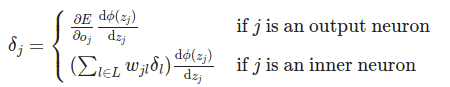


Here $E$ is the error, $w_{ij}$ the weights, $z_j$ the weighted sum computed by each neuron before activation, $\phi$ the activation function applied on this sum, and $L$ all the neurons directly conneted to the ouput $o_j$ of neuron $j$. The recursive character of the gradient calculation is clearly visible in the sum on the elements of $L$ in which we need $\delta_l$.


And so we can update the weights using a pre-specified learning rate $\eta$:

$ \Delta w_{ij} = -\eta \frac{\partial E}{\partial w_{ij}} $.

Hence, for each training step, we need to: 
- first compute the error **(forward pass)**,
- propagate the error from the last layer to the first **(backwards pass - or backpropagation)**.

##### Loss function
Of course, we are still missing an error (or loss) function for the output layer. 

There is a whole zoo of loss functions that can be used. Traditionally, the *mean squared error* is used on *regression* problems. Here we are doing **binary classification**. However we can apply the same methods as in the more general **multi-class** problem which relies on one-hot encoding (which is the way we prepared our dataset).

We can use the **categorical-cross entropy** which measures the difference between the output discrete probability distribution (obtained with our softmax activation) and our target distribution (here a one-hot encoding).

(For more info there is a great introduction to cross-entropy from Jason Brownlee https://machinelearningmastery.com/cross-entropy-for-machine-learning/)

#####Optimizer

Finally, the simple gradient descent we have described can be significantly improved and several optimizers are implemented in Keras, which offer better results depending on the problem: Stochastic gradient Descent (SGD; which we use in this tutorial, as it is the most basic optimizer), ADAM, AdaDelta, RMSProp... 

<img src="https://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif" alt="Comparison of optimizer performance" width="300"/>
(Image credit Sebastian Ruder)

(For more info see this excellent article by Sebastian Ruder: https://ruder.io/optimizing-gradient-descent/)



---


Okay, let's fit the model! That's easy to do with a model.fit() command. 



The first argument to model.fit() is the "x" or "independent variable", which in our case is a set of images. The second argument is the "y" or "dependent variable", or "target classification", which in our case is an array of one-hot encoded labels.


In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_val, y_val))

A couple of things to explain here: 

- We store in `history` metrics for each epoch of the training. They will be usefull to assess convergence.
- The `batch_size` is the size of the sample we feed to the network for each weight update. It can be at most the sample size, but a large batch size leads to **overfitting**. Decreasing the batch size means that the model has less information to carry out this update, leading to less overfitting. We feed successive batches eventually covering the whole sample after one **epoch**.
- `epochs` is the number of epochs to train for.

We can also directly fit using the tf.data.Dataset objects we created earlier.
If you want to try this, be sure to re-run the model definition and compilation steps first! Otherwise you will be using the pre-trained model from the previous step. Then, comment out the first command in this cell, and uncomment this next one.

In [ ]:
# model.fit(train_dataset, epochs=30)

Note that when the data have already been packaged into tf.data.Dataset objects,we no longer need to provide data & labels to model.fit() separately.

## Validation

Great, we can do very well on the training set! But how well does the model work on data it has never seen before? For that, let's generate predictions on the test data set. Remember, the model has not seen these data yet.

In [ ]:
predictions = model.predict(X_test)

This tells us a "probability" that the object is in class 0 or class 1. We can now convert each of these to a class label, running from 0 to N, where N is the number of classes


In [ ]:
predictions_labels = tf.argmax(predictions, axis = 1)
test_labels        = tf.argmax(y_test, axis = 1)

We can use these class labels to calculate a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_labels,predictions_labels))

There's also a tensorflow version of this function

In [ ]:
# tf.math.confusion_matrix(test_labels,predictions_labels)

This tells us how many objects of class 0 are classified as 0 or 1 and how many objects of class 1 are classified as class 0 or 1. You can get fancy and turn this into fractions and then plot it to make the shiny confusion matrix plots people have in their papers. As far as we know, you need to write your own code to make such a plot.

In [ ]:
# sklearn also has a shiny classification report function, which will 
# calculate the precision, recall, and f1-scores for us

from sklearn.metrics import classification_report
print(classification_report(test_labels,predictions_labels))

- The precision (or correctness) `true_positive/(true_positive+false_positive)` is the ability of the classifier not to label as positive a sample that is negative.
- The recall (or completeness) `true_positive/(true_positive+false_negative)` is the ability of the classifier to find all the positive samples.
- The F1 score is the harmonic mean of the two and measures the preformance of the classifier : $F_1 = \frac{2}{\mathrm{precision}^{-1}+\mathrm{recall}^{-1}}$

Now let us see how fast the model has converged. For this we plot the metrics as function of the epochs. This measure of convergence will be used under the hood when tuning the hyperparameters of the model.

In [ ]:
# Let us see how fast the model has converged
# For this we can plot the training and validation accuracy (or the loss)
# as a function of epoch number

def convergence(history):

    history = history.history

    loss = history["loss"]
    val_loss = history["val_loss"]
    nepochs = len(loss)

    accuracy = history["accuracy"]
    val_accuracy = history["val_accuracy"]

    plt.plot(np.arange(nepochs), loss, "k-", label="training loss")
    plt.plot(np.arange(nepochs), val_loss, "k--", label="validation loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(frameon=False)
    plt.show()

    plt.plot(np.arange(nepochs), accuracy, "k-", label="training accuracy")
    plt.plot(np.arange(nepochs), val_accuracy, "k--", label="validation accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(frameon=False)
    plt.show()

convergence(history)

## Hyperparameter tuning

The model can further be improved by optimizing various parameters.
- Optimisation of network architecture (number/size of layers...)
- Optimisation of training parameters (learning rate, number of epochs...)

Several modules exist to train Keras models: Hyperas, Talos, Keras Tuner...
\
Hyperas does not support Tensorflow 2.0 and Talos does not have Bayesian Optimisation. 

**Keras Tuner** is the most complete package currently available
and can be used on Sequential and Functional models.

(Before we start, this post by Ke Gui might save beginners  a lot of time when debugging: https://kegui.medium.com/a-few-pitfalls-for-kerastuner-beginner-users-13116759435b)

Okay let's get to it!

In [ ]:
#installing and importing Keras Tuner
!pip install -q -U keras-tuner
import kerastuner as kt

The model architecture, including the parameters to optimise, are contained in a model builder function that takes as argument a hyperparameter `hp` attribute of the HyperModel class. This attribute can be used in the following ways:
- Parameter tuning: Instead of passing constants to layer keyword arguments, we pass a set of hyperparameters
- Model Architecture: can be changed functionally based on a set of hyperparameters.

Here we optimise for:
   - Number of convolutional blocks (hyperparameter `"conv_blocks"`)
   - Number of filters in each convolutional block (`"filters_i"`)
   - Number of units in the first and second dense layers (`"units_01"` and `"units_02"`)
   - Learning rate (`"learning_rate"`)

We use the functions `hp.Int()` and `hp.Choice()` to specify a set of integers, or a set of user-defined values, respectively, for a hyperparameter.


In [ ]:
# Example inspired from the Keras Team tutorial:
# https://github.com/keras-team/keras-tuner/blob/master/examples/cifar10.py

def model_builder(hp):

  filter_size = 3
  fs = filter_size
  
  from tensorflow.keras.layers import Input
  # Beginning of our model
  # ----------------------
  inputs = Input(shape=(N_image, N_image, 1)) # input layer
  x = inputs  # giving a generic name to the tensor going through the model
  # We can re-use the same name for multiple layers, making it easier to
  # amend the functional model.

  # Choosing the number of convolutional blocks
  for i in range(hp.Int("conv_blocks", 2, 4, default=3)):
    # choosing the number of filters
    filters = hp.Int("filters_" + str(i), 8, 32, step=8) 
    for _ in range(2): # 2 layers per conv block
      x = layers.Conv2D(
          filters, kernel_size=(fs, fs), padding="same", activation='relu'
          )(x)
    x = layers.MaxPooling2D((2, 2))(x)

  x = layers.Flatten()(x)

  # optimising the nuber of units in the first dense layer
  hp_units_01 = hp.Int('units_01', min_value=32, max_value=128, step=32)
  x = layers.Dense(units=hp_units_01, activation='relu')(x)

  # optimising the nuber of units in the second dense layer
  # (notice that both hyperparameter objects are name differently)
  hp_units_02 = hp.Int('units_02', min_value=16, max_value=64, step=16)
  x = layers.Dense(units=hp_units_02,activation='relu')(x)

  outputs = layers.Dense(2,activation='softmax')(x)
  # ---------------
  # End of our model

  # Set up the model using the functional API
  model = models.Model(inputs, outputs)

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # copile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model

Now that we have declared our model builder, we need to initialise the tuner which will operate the search in the hyperparameters.
Keras Tuner has four tuners available - *RandomSearch*, *Hyperband*, *BayesianOptimization*, and *Sklearn*

We will use the state of the art **Hyperband** algorithm which presents the advantage of providing early-stopping for poor models and parallelisation. However the process remains the same for all other optimisers.

In [ ]:
tuner = kt.Hyperband(model_builder,             # hypermodel
                     objective='val_accuracy',  # score
                     max_epochs=20)

# create a callback for early stopping
# stops if validation loss does not increase for more than 'patience' epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Searching for the best parameters
tuner.search(X_train_full, y_train_full,
             epochs=20, validation_split=0.2, callbacks=[stop_early])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  # returns a list of num_trials hyperparameters ranked from best to worst

# printing information about best model:
print(f"""
Best Model:
conv_blocks: {best_hps.get('conv_blocks')}
filters_0 = {best_hps.get('filters_0')}
filters_1 = {best_hps.get('filters_1')}
filters_2 = {best_hps.get('filters_2')}
units_01 = {best_hps.get('units_01')}
units_02 = {best_hps.get('units_02')}
learning_rate = {best_hps.get('learning_rate')}
""")

Keras Tuner can be used to optimise more parameters such as the **activation function** of a given layer, the **gradient descent** algorithm to use etc...

We can now train our best model before evaluating its performance.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hyperhistory = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Let's evaluate our new model:

In [ ]:
convergence(hyperhistory)

In [ ]:
hyperpredictions = hypermodel.predict(X_test)
hyperpredictions_labels = tf.argmax(hyperpredictions, axis = 1)
test_labels        = tf.argmax(y_test, axis = 1)
print(confusion_matrix(test_labels,hyperpredictions_labels))

Our original model was already showing really good performance, and our classification problem is quite a simple one, so the gain we have here is marginal. However, when working on more complex problems, significant improvement can be expected from tuning our model properly.

---
---
# Final thoughts

Thanks for following this tutorial! We've covered the following:
- How to prepare your data for image classification.
- How to build and train a CNN using tensorflow and Keras.
- How to evaluate the performance of a classification model.
- How to optimise the model for faster training and better classification.

We've also introduced the following libraries for ML: **Tensorflow, Keras, Scikit-Learn**.

In a lot of applications where datasets have various features (unlike images with only pixels), **Pandas** will become very helpful. Finally, in these cases, **standardisation** of your dataset will be crucial if you want your model to converge, which we have not covered in this tutorial.

That's it!

Happy Machine Learning!

## Reusing or adapting this tutorial
If you find this tutorial helpful and would like us to deliver it at your institution, please contact the authors. 

We hope this tutorial gives you a quick, practical introduction to the world of machine learning for astronomy. Academic reward systems for service work like this are limited. If the use of this tutorial enables you to go on to publish any research articles in the future, please consider listing us in your acknowledgements.  

This work is released under the [Creative Commons CC BY-NC-SA license](https://creativecommons.org/licenses/by-nc-sa/4.0/). You are free to distribute, remix, adapt, and build upon this material in any medium for non-commercial purposes, provided you attribute the original source and the creators. Any adapted material based on this tutorial must be released under identical terms. 

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Fully connected Neural Network" width="200"/>


